In [12]:
# Load Packages

import time, wave
import os
import pyaudio
import contextlib
import re
import pydub
import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display
import pandas as pd
from pydub import AudioSegment
from pydub.playback import play
from datetime import datetime
import time
from time import sleep

In [13]:
# Define Functions

In [14]:
def normalize_audio(filename,inputpath,outputpath,stripstartingsoundbelowthreshold,stripendingsoundbelowthreshold,target_dBFS):
    
    # Load Audio File
    sf_filewave = wave.open(os.path.join(inputpath,filename), 'r')
    
    # Get Stats
    signal_sf = sf_filewave.readframes(-1)
    # Convert audio bytes to integers
    soundwave_sf = np.frombuffer(signal_sf, dtype='int16')
    # Get the sound wave frame rate
    framerate_sf = sf_filewave.getframerate()
    # Find the sound wave timestamps
    time_sf = np.linspace(start=0,
                      stop=len(soundwave_sf)/framerate_sf,
                      num=len(soundwave_sf))
    
    # Build Dataframe with Amplitude Against Time
    amplitudedf=pd.DataFrame({'time_sf':time_sf, 'soundwave_sf':soundwave_sf})

    start=amplitudedf[abs(amplitudedf['soundwave_sf'])>=stripstartingsoundbelowthreshold].iloc[:,0].min()*1000
    end=amplitudedf[abs(amplitudedf['soundwave_sf'])>=stripendingsoundbelowthreshold].iloc[:,0].max()*1000

    #     print(start)
    #     print(end)

    # Strip Blank Audio & Export
    newAudio=AudioSegment.from_wav(os.path.join(inputpath,filename))
    newAudio=newAudio[start:end]  
    newAudio.export(os.path.join(outputpath,filename), format="wav")
    
    # Load New Audio File
    sf_filewave = wave.open(os.path.join(outputpath,filename), 'r')
    
    # Get Stats
    signal_sf = sf_filewave.readframes(-1)
    # Convert audio bytes to integers
    soundwave_sf = np.frombuffer(signal_sf, dtype='int16')
    # Get the sound wave frame rate
    framerate_sf = sf_filewave.getframerate()
    # Find the sound wave timestamps
    time_sf = np.linspace(start=0,
                      stop=len(soundwave_sf)/framerate_sf,
                      num=len(soundwave_sf))
    
    # Normalize Volume
    
    def set_loadness(audio_segment,target_dBFS):
        loudness_difference=target_dBFS-audio_segment.dBFS
        audio_segment=audio_segment+loudness_difference
        return audio_segment

    newAudio=AudioSegment.from_wav(os.path.join(outputpath,filename))

    newAudio=set_loadness(newAudio,target_dBFS)

    # Export Final File
    newAudio.export(os.path.join(outputpath,filename), format='wav')
    
    print(f"""Prepared Audio Available at the Following Path: {os.path.join(outputpath,filename)}""")

In [15]:
def manually_clip_end(filenumber,prefix,path,end):
    
    filename=f"""{prefix}_{filenumber}.wav"""
    
    start=0
    end=end*1000

    # Strip Blank Audio & Export
    newAudio=AudioSegment.from_wav(os.path.join(path,filename))
    newAudio=newAudio[start:end]
    
    def set_loadness(audio_segment,target_dBFS):
        loudness_difference=target_dBFS-audio_segment.dBFS
        audio_segment=audio_segment+loudness_difference
        return audio_segment

    newAudio=set_loadness(newAudio,target_dBFS)
    
    newAudio.export(os.path.join(path,filename), format="wav")
    
    print(f"""Prepared Audio Available at the Following Path: {os.path.join(path,filename)}""")

In [16]:
def manually_clip_start(filenumber,prefix,path,start):
    
    filename=f"""{prefix}_{filenumber}.wav"""
    
    # Load Audio File
    sf_filewave = wave.open(os.path.join(path,filename), 'r')
    
    # Get Stats
    signal_sf = sf_filewave.readframes(-1)
    # Convert audio bytes to integers
    soundwave_sf = np.frombuffer(signal_sf, dtype='int16')
    # Get the sound wave frame rate
    framerate_sf = sf_filewave.getframerate()
    # Find the sound wave timestamps
    time_sf = np.linspace(start=0,
                      stop=len(soundwave_sf)/framerate_sf,
                      num=len(soundwave_sf))
    
    # Build Dataframe with Amplitude Against Time
    amplitudedf=pd.DataFrame({'time_sf':time_sf, 'soundwave_sf':soundwave_sf})
    
    end=amplitudedf['time_sf'].max()*1000
    
    start=start*1000

    # Strip Blank Audio & Export
    newAudio=AudioSegment.from_wav(os.path.join(path,filename))
    newAudio=newAudio[start:end]  
    
    def set_loadness(audio_segment,target_dBFS):
        loudness_difference=target_dBFS-audio_segment.dBFS
        audio_segment=audio_segment+loudness_difference
        return audio_segment

    newAudio=set_loadness(newAudio,target_dBFS)
    
    newAudio.export(os.path.join(path,filename), format="wav")
    
    print(f"""Prepared Audio Available at the Following Path: {os.path.join(path,filename)}""")

In [17]:
def compare_amplitude(filenumber,prefix,inputpath,outputpath,delay):
    
    filename=f"""{prefix}_{filenumber}.wav"""
    
    print(filenumber)
    
    # Input
    # Open wav file and read frames as bytes
    sf_filewave = wave.open(os.path.join(inputpath,filename), 'r')
    signal_sf = sf_filewave.readframes(-1)
    # Convert audio bytes to integers
    soundwave_sf = np.frombuffer(signal_sf, dtype='int16')
    # Get the sound wave frame rate
    framerate_sf = sf_filewave.getframerate()
    # Find the sound wave timestamps
    time_sf = np.linspace(start=0,
                      stop=len(soundwave_sf)/framerate_sf,
                      num=len(soundwave_sf))
    sf_filewave.close()
    
    # Ouput
    # Open wav file and read frames as bytes
    sf_filewave1 = wave.open(os.path.join(outputpath,filename), 'r')
    signal_sf1 = sf_filewave1.readframes(-1)
    # Convert audio bytes to integers
    soundwave_sf1 = np.frombuffer(signal_sf1, dtype='int16')
    # Get the sound wave frame rate
    framerate_sf1 = sf_filewave1.getframerate()
    # Find the sound wave timestamps
    time_sf1 = np.linspace(start=0,
                      stop=len(soundwave_sf1)/framerate_sf1,
                      num=len(soundwave_sf1))
    sf_filewave1.close()
    
    # Set up plot
#     f, ax = plt.subplots(figsize=(15, 3))
    fig, axs = plt.subplots(2)
    # Setup the title and axis titles
    fig.suptitle('Amplitude over Time')
#     plt.title('Amplitude over Time')
#     plt.ylabel('Amplitude')
#     plt.xlabel('Time (seconds)')
    # Add the audio data to the plot
#     axs[0] = plt.plot(time_sf, soundwave_sf, label='Warm Memories', alpha=0.5)
#     axs[1] = plt.plot(time_sf1, soundwave_sf1, label='Warm Memories 2', alpha=0.5)
    
    axs[0].plot(time_sf, soundwave_sf, alpha=0.5)
    axs[1].plot(time_sf1, soundwave_sf1, alpha=0.5)
#     plt.legend()
    plt.show()

    sleep(delay)

In [18]:
def get_wordcount(filenumber,prefix,transcriptpath,useindex):
    filename=f"""{prefix}_{filenumber}.wav"""
    
    # Get Word Count
    with open(transcriptpath,'r', encoding="utf8") as f:
        lines=f.readlines()
        for i, line in enumerate(lines, start=1):
            if useindex==False:
                if int(re.search('_(.*).wav', line).group(1))==int(re.search('_(.*).wav', filename).group(1)):
                    wordcount=len(line.split("|",1)[1].split())
            else: 
                if i==filenumber:
                    wordcount=len(line.split("|",1)[1].split())
                
    try: wordcount=wordcount
    except: 
        wordcount=0
        print(f"""no wordcount for filenumber: {filenumber}""")
                
    return wordcount

In [19]:
def get_duration(filenumber,prefix,audiopath):
    filename=f"""{prefix}_{filenumber}.wav"""
    
    # Get Audio Duration
    sf_filewave = wave.open(os.path.join(audiopath,filename), 'r')
    signal_sf = sf_filewave.readframes(-1)
    # Convert audio bytes to integers
    soundwave_sf = np.frombuffer(signal_sf, dtype='int16')
    # Get the sound wave frame rate
    framerate_sf = sf_filewave.getframerate()
    # Find the sound wave timestamps
    time_sf = np.linspace(start=0,
                      stop=len(soundwave_sf)/framerate_sf,
                      num=len(soundwave_sf))
    sf_filewave.close()
    f.close()

    duration=time_sf.max()/60
    
    return duration

In [20]:
def get_wpm(filenumber,prefix,audiopath,transcriptpath,useindex):
    
    if useindex==False:
        filename=f"""{prefix}_{filenumber}.wav"""
    else: filename=os.listdir(audiopath)[filenumber-1]
    
    # Get Word Count
    with open(transcriptpath,'r', encoding="utf8") as f:
        lines=f.readlines()
        for i, line in enumerate(lines, start=1):
            if useindex==False:
                if int(re.search('_(.*).wav', line).group(1))==int(re.search('_(.*).wav', filename).group(1)):
                    wordcount=len(line.split("|",1)[1].split())
            else: 
                if i==filenumber:
                    wordcount=len(line.split("|",1)[1].split())
                
    # Get Audio Duration
    sf_filewave = wave.open(os.path.join(audiopath,filename), 'r')
    signal_sf = sf_filewave.readframes(-1)
    # Convert audio bytes to integers
    soundwave_sf = np.frombuffer(signal_sf, dtype='int16')
    # Get the sound wave frame rate
    framerate_sf = sf_filewave.getframerate()
    # Find the sound wave timestamps
    time_sf = np.linspace(start=0,
                      stop=len(soundwave_sf)/framerate_sf,
                      num=len(soundwave_sf))
    sf_filewave.close()
    f.close()
    
    duration=time_sf.max()/60
    
    try: wpm=wordcount/duration
    except: 
        wpm=0
        print(f"""no wordcount for filenumber: {filenumber}""")
    
    return wpm

In [21]:
def play_with_transcription(filenumber,prefix,inputpath,outputpath,transcriptpath,playinput,playoutput):
    
    filename=f"""{prefix}_{filenumber}.wav"""
    
    print(filenumber)
    
    with open(transcriptpath,'r') as f:
        lines=f.readlines()
        for line in lines:
            if int(re.search('_(.*).wav', line).group(1))==int(re.search('_(.*).wav', filename).group(1)):
                print(line.split("|",1)[1])                              
            
    # Input
    # Open wav file and read frames as bytes
    sf_filewave = wave.open(os.path.join(inputpath,filename), 'r')
    signal_sf = sf_filewave.readframes(-1)
    # Convert audio bytes to integers
    soundwave_sf = np.frombuffer(signal_sf, dtype='int16')
    # Get the sound wave frame rate
    framerate_sf = sf_filewave.getframerate()
    # Find the sound wave timestamps
    time_sf = np.linspace(start=0,
                      stop=len(soundwave_sf)/framerate_sf,
                      num=len(soundwave_sf))
    sf_filewave.close()
    f.close()

    # Ouput
    # Open wav file and read frames as bytes
    sf_filewave1 = wave.open(os.path.join(outputpath,filename), 'r')
    signal_sf1 = sf_filewave1.readframes(-1)
    # Convert audio bytes to integers
    soundwave_sf1 = np.frombuffer(signal_sf1, dtype='int16')
    # Get the sound wave frame rate
    framerate_sf1 = sf_filewave1.getframerate()
    # Find the sound wave timestamps
    time_sf1 = np.linspace(start=0,
                      stop=len(soundwave_sf1)/framerate_sf1,
                      num=len(soundwave_sf1))
    sf_filewave1.close()
    
    # Set up plot
    fig, axs = plt.subplots(2)
    fig.suptitle('Amplitude over Time')
    axs[0].plot(time_sf, soundwave_sf, alpha=0.5)
    axs[1].plot(time_sf1, soundwave_sf1, alpha=0.5)
    
    plt.show() 
    
    for i,path in enumerate([inputpath,outputpath]):
        
        if ((i==0)&(playinput) or (i==1)&(playoutput)):
        
            with wave.open(os.path.join(path,filename), 'rb') as f:

                p = pyaudio.PyAudio()  
                #open stream  
                stream = p.open(format = p.get_format_from_width(f.getsampwidth()),  
                    channels = f.getnchannels(),  
                    rate = f.getframerate(), 
                    output = True)  

                #define stream chunk   
                chunk = 1024  

                #read data  
                data = f.readframes(chunk)  

                #play stream  
                while data:  
                    stream.write(data)  
                    data = f.readframes(chunk)  

                #stop stream  
                stream.stop_stream()  
                stream.close()  

                #close PyAudio  
                p.terminate() 
        
                f.close()

In [22]:
def make_edits_live(audiodirectorypath,includetrain,includevalidation):
    currentdatetime=datetime.now().strftime("%Y-%m-%d %H%M")
    try: 
        if includetrain:
            os.rename(audiodirectorypath+'train\\',audiodirectorypath+f"""archive\\train\\{currentdatetime}""")
            os.rename(audiodirectorypath+'edited\\train\\',audiodirectorypath+f"""train\\""")
        if includevalidation:
            os.rename(audiodirectorypath+'validation\\',audiodirectorypath+f"""archive\\validation\\{currentdatetime}""")
            os.rename(audiodirectorypath+'edited\\validation\\',audiodirectorypath+f"""validation\\""")
    except: print('archive directory already exists with that date time')

In [23]:
# Set Environment Path

environmentpath='<insert environment path>'

In [25]:
# Automatically Normalize Audio

# Train

prefix='AC'
inputpath=f"""{environmentpath}AC Voice Cloning Data Archive Dec 8\\wavs\\train\\"""
outputpath=f"""{environmentpath}AC-Voice-Cloning-Data-Test\\wavs\\edited\\train\\"""
target_dBFS=-23.7

# Adjust values as needed and based on output recordings
stripstartingsoundbelowthreshold=500
stripendingsoundbelowthreshold=150

for i, filename in enumerate(os.listdir(inputpath), start=1):
    normalize_audio(filename,inputpath,outputpath,stripstartingsoundbelowthreshold,stripendingsoundbelowthreshold,target_dBFS)
    
# Test

inputpath=f"""{environmentpath}AC Voice Cloning Data Archive Dec 8\\wavs\\validation\\"""
outputpath=f"""{environmentpath}AC-Voice-Cloning-Data-Test\\wavs\\edited\\validation\\"""

for i, filename in enumerate(os.listdir(inputpath), start=1):
    normalize_audio(filename,prefix,inputpath,outputpath,stripstartingsoundbelowthreshold,stripendingsoundbelowthreshold,target_dBFS)

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_10.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_100.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1000.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1001.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1002.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1003.wav
Prepared Audio Available a

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1055.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1056.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1057.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1058.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1059.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_106.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1060.wav
Prepared Audio Availa

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_111.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1110.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1111.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1112.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1113.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1114.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1115.wav
Prepared Audio Availa

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1167.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1168.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1169.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_117.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1170.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1171.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1172.wav
Prepared Audio Availa

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1222.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1223.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1224.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1225.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1226.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1227.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_1228.wav
Prepared Audio Avail

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_156.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_157.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_158.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_159.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_16.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_160.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_161.wav
Prepared Audio Available at 

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_212.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_213.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_214.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_215.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_216.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_217.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_218.wav
Prepared Audio Available at

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_270.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_271.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_272.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_273.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_274.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_275.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_276.wav
Prepared Audio Available at

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_325.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_326.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_327.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_328.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_329.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_33.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_330.wav
Prepared Audio Available at 

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_382.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_383.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_384.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_385.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_386.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_387.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_388.wav
Prepared Audio Available at

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_435.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_436.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_437.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_438.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_439.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_44.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_440.wav
Prepared Audio Available at 

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_49.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_490.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_491.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_492.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_493.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_494.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_495.wav
Prepared Audio Available at 

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_543.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_544.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_545.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_546.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_547.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_548.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_549.wav
Prepared Audio Available at

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_6.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_60.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_600.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_601.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_602.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_603.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_604.wav
Prepared Audio Available at th

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_652.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_653.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_654.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_655.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_656.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_657.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_658.wav
Prepared Audio Available at

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_710.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_711.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_712.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_713.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_714.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_715.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_716.wav
Prepared Audio Available at

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_767.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_768.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_769.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_77.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_770.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_771.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_772.wav
Prepared Audio Available at 

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_824.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_825.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_826.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_827.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_828.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_829.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_83.wav
Prepared Audio Available at 

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_878.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_879.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_88.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_880.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_881.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_882.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_883.wav
Prepared Audio Available at 

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_932.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_933.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_934.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_935.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_936.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_937.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_938.wav
Prepared Audio Available at

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_99.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_990.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_991.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_992.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_993.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_994.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_995.wav
Prepared Audio Available at 

TypeError: normalize_audio() takes 6 positional arguments but 7 were given

In [ ]:
# Automatically Normalize Audio

# Train

prefix='AC'
inputpath=f"""{environmentpath}<path to folder with recordings in chronological order>"""
outputpath=f"""{environmentpath}AC-Voice-Cloning-Data-Test\\wavs\\edited\\train\\"""
target_dBFS=-23.7

# Adjust values as needed and based on output recordings
stripstartingsoundbelowthreshold=500
stripendingsoundbelowthreshold=150

for i, filename in enumerate(os.listdir(inputpath), start=1):
    normalize_audio(filename,inputpath,outputpath,stripstartingsoundbelowthreshold,stripendingsoundbelowthreshold,target_dBFS)
    
# Test

inputpath=f"""{environmentpath}<path to folder with recordings in chronological order>"""
outputpath=f"""{environmentpath}AC-Voice-Cloning-Data-Test\\wavs\\edited\\validation\\"""

for i, filename in enumerate(os.listdir(inputpath), start=1):
    normalize_audio(filename,prefix,inputpath,outputpath,stripstartingsoundbelowthreshold,stripendingsoundbelowthreshold,target_dBFS)

In [40]:
range(start,end)

range(0, 2)

In [44]:
start=2
end=2
range(start-1,end)
for i in range(start-1,end):
    print(i)

1


1


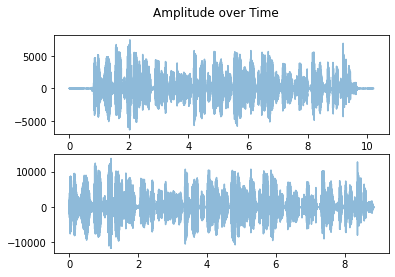

In [45]:
# Visualize Audio Before & After Normalization

inputpath=f"""{environmentpath}<path to folder with recordings in chronological order>"""
outputpath=f"""{environmentpath}AC-Voice-Cloning-Data-Test\\wavs\\edited\\train\\"""
start=2
end=2

for i in range(start-1,end):
    compare_amplitude(i,prefix,inputpath,outputpath,0)

Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_16.wav
Prepared Audio Available at the Following Path: C:\Users\andrew.charabin\Downloads\AC-Voice-Cloning-Data-Test\wavs\edited\train\AC_16.wav
16


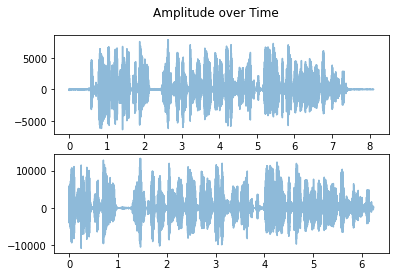

In [28]:
# If Necessary, Manually Clip Audio Start & End

manually_clip_end(16,prefix,outputpath,6.5)
manually_clip_start(16,prefix,outputpath,0.15)

compare_amplitude(16,prefix,inputpath,outputpath,0)

500
that a strict compliance with their duties gave them no choice "but to report matters as we found them,



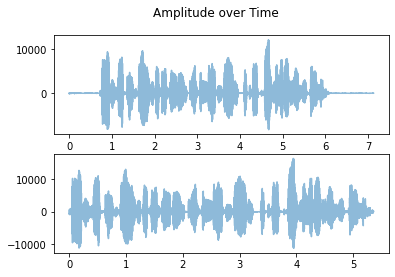

In [31]:
filenumber=500
transcriptpath=f"""{environmentpath}AC-Voice-Cloning-Data-Test\\filelists\\audio\\acs_audio_text_train_filelist.txt"""

play_with_transcription(filenumber,prefix,inputpath,outputpath,transcriptpath,False,True)

In [44]:
# Replace Official Files with Edited Files

# Train

audiodirectorypath=f"""{environmentpath}AC-Voice-Cloning-Data-Test\\wavs\\"""
make_edits_live(audiodirectorypath,True,False)

# Validation

audiodirectorypath=f"""{environmentpath}AC-Voice-Cloning-Data-Test\\wavs\\"""
make_edits_live(audiodirectorypath,False,True)